# Visualization Examples using Cedalion Plot Functions
This notebook will be continuously extended. We un-necessarily re-import cedalion dependencies to clarify which of these are needed for the plots in each corresponding cell. PLEASE NOTE: we are in the process of re-organizing the locations for our plotting functions. This notebook will be kept up to date with the latest release to enable an easy look up. 

## Importing Packages
### 3rd party plotting packages
Most of Cedalion's plotting functionality is based on Matplotlib and Pyvista packages

In [1]:
import pyvista as pv
#pv.set_jupyter_backend('server') # this enables interactive plots
pv.set_jupyter_backend('static') # this enables static rendering
#pv.OFF_SCREEN=True

import matplotlib.pyplot as p

### Other packages that will be useful in this notebook
Dependencies for data processing and manipulation. 

In [2]:
import time
import numpy as np
import xarray as xr

## Load Data for Visuatization
This cell fetches a variety example datasets from the cloud for visualization. This can take a bit of time.

In [3]:
import cedalion
import cedalion.datasets
import cedalion.io
import cedalion.imagereco.forward_model as fw

# Loads a high-density finger tapping fNIRS example snirf dataset into a recording container
cedalion.units
rec = cedalion.datasets.get_fingertappingDOT()

# Loads a photogrammetric example scan
fname_scan, fname_snirf, fname_montage = cedalion.datasets.get_photogrammetry_example_scan()
pscan = cedalion.io.read_einstar_obj(fname_scan)

# Loads a precalculated example fluence profile that does not belong with this recording though
fluence_all, fluence_at_optodes = cedalion.datasets.get_precomputed_fluence("fingertappingDOT", "colin27")

# Lads a segmented MRI Scan (here the Colin27 average brain) and creates a TwoSurfaceHeadModel
SEG_DATADIR, mask_files, landmarks_file = cedalion.datasets.get_colin27_segmentation()
head = fw.TwoSurfaceHeadModel.from_segmentation(
    segmentation_dir=SEG_DATADIR,
    mask_files = mask_files,
    landmarks_ras_file=landmarks_file
)


## Plotting Time Series Using Matplotlib
We are working on a nice function that abstracts most of the work away from you. Until then you will have use standard python matplotlib functions.

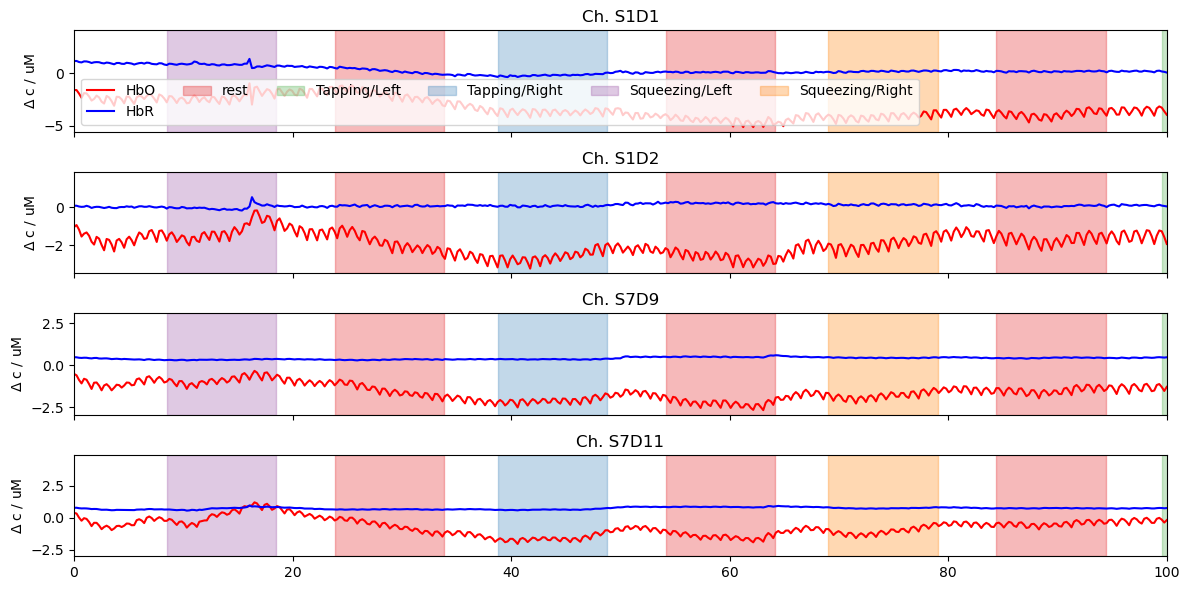

In [4]:
import cedalion.nirs as nirs
import cedalion.plots as plots
import matplotlib.pyplot as plt 

# calculate HbO/HbR from raw data
dpf = xr.DataArray(
        [6, 6],
        dims="wavelength",
        coords={"wavelength": rec["amp"].wavelength},
    )
rec["conc"] = nirs.beer_lambert(rec["amp"], rec.geo3d, dpf, spectrum = "prahl")
# rename events
rec.stim.cd.rename_events(
        {"1": "rest", "2": "Tapping/Left", "3": "Tapping/Right", "4": "Squeezing/Left", "5": "Squeezing/Right"}
    )

# select which time series we work with
ts = rec["conc"]

# Thanks to the xarray DataArray structure, we can easily select the data we want to plot
# plot four channels and their stim markers
f, ax = plt.subplots(4, 1, sharex=True, figsize=(12, 6))
for i, ch in enumerate(["S1D1", "S1D2", "S7D9", "S7D11"]):
    ax[i].plot(ts.time, ts.sel(channel=ch, chromo="HbO"), "r-", label="HbO")
    ax[i].plot(ts.time, ts.sel(channel=ch, chromo="HbR"), "b-", label="HbR")
    ax[i].set_title(f"Ch. {ch}")
    # add stim markers using Cedalion's plot_stim_markers function
    cedalion.plots.plot_stim_markers(ax[i], rec.stim, y=1)
    ax[i].set_ylabel(r"$\Delta$ c / uM")

ax[0].legend(ncol=6)
ax[3].set_label("time / s")
ax[3].set_xlim(0,100)
plt.tight_layout()


## Scalp Plot
Plots a metric, e.g. channel quality or amplitude at a time point on the scalp.

c:\Users\avonl\anaconda3\envs\cedalion\Lib\site-packages\xarray\core\variable.py:338: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


c:\Users\avonl\anaconda3\envs\cedalion\Lib\site-packages\xarray\core\variable.py:338: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


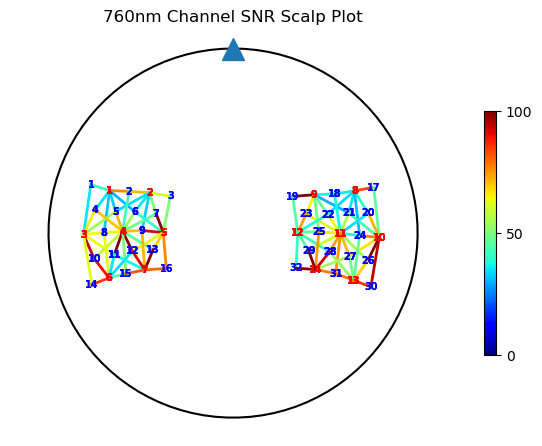

In [5]:
import cedalion.plots as plots
import cedalion.sigproc.quality as quality
import matplotlib.pyplot as plt 

n_channels = len(rec["amp"].channel)
# Calculate channel SNR to display as a metric in the plot
snr, snr_mask = quality.snr(rec["amp"], 3)
# the plots "metric" input needs dimension (nchannels,) so we focus on the 760nm wavelength for each channel
snr_metric = snr.sel(wavelength="760").values

# Create scalp plot showing SNR in each channel
fig, ax = plt.subplots(1,1)
plots.scalp_plot(rec, snr_metric, ax, colormap=plt.cm.jet, title='760nm Channel SNR Scalp Plot', vmin=0, vmax=n_channels, savePath = None, flagFontSize=7, flagMarkerSize=0)


## Plotting Time Series Using an interactive GUI
run_vis() from the vis.timeseries package

In [6]:
from cedalion.vis import time_series

# this calls a GUI to interactively select channels from a 2D probe. 
# Input is a recording container, you can choose which time series (e.g. raw, OD, concentrations) in the container  to plot

# UNCOMMENT to use the GUI. Commented out for documentation autogeneration purposes.
#time_series.run_vis(rec)

SystemExit: 0

![GUI_Snapshot](../img/time_series_guiexample.png)

## Plotting an fNIRS Montage in 3D
Using **plot_montage3D()**

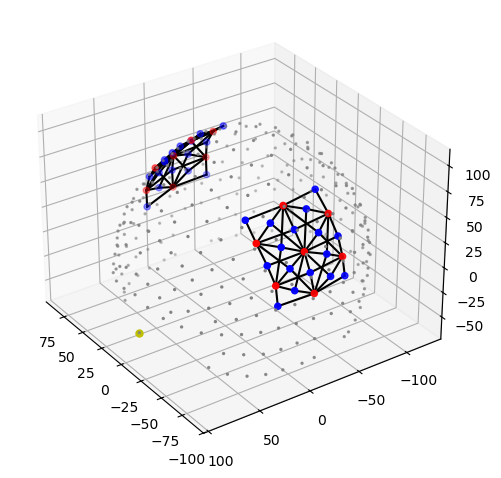

In [7]:
import cedalion.plots

# use the plot_montage3D() function. It requires a recording container and a geo3d object
cedalion.plots.plot_montage3D(rec["amp"], rec.geo3d)

## Plotting a Headmodel
For instance the default Colin27 or ICBM152, using **plot_surface()**

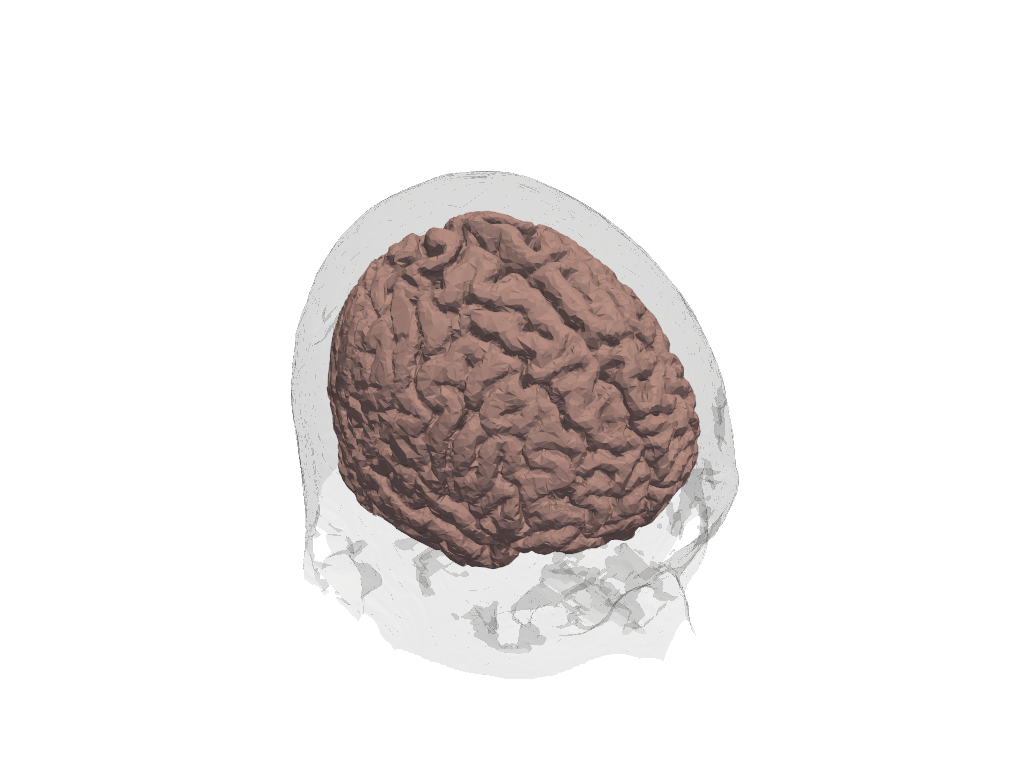

In [8]:
import cedalion.plots

plt = pv.Plotter()
cedalion.plots.plot_surface(plt, head.brain, color="#d3a6a1")
cedalion.plots.plot_surface(plt, head.scalp, opacity=.1)
plt.show()

### Adding a montage to the headmodel
For this the montage has to be registered to the headmodel's scalp first. Then we use **plot_labeled_points**

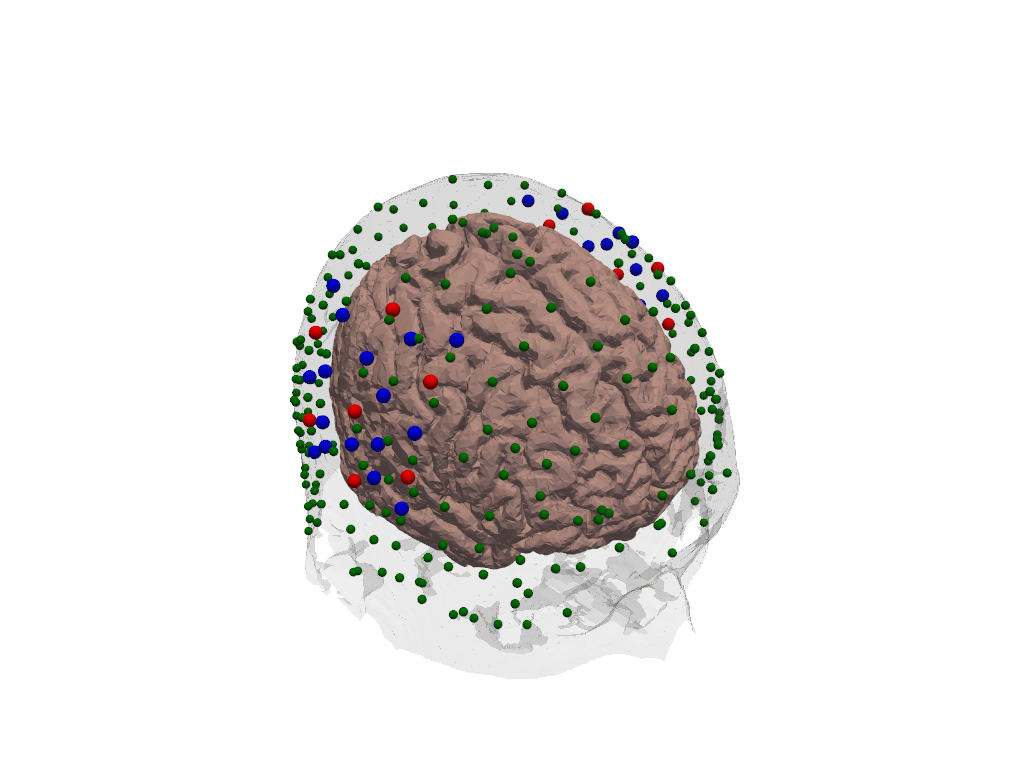

In [9]:
geo3d_snapped = head.align_and_snap_to_scalp(rec.geo3d)

# now we plot the head same as before...
plt = pv.Plotter()
cedalion.plots.plot_surface(plt, head.brain, color="#d3a6a1")
cedalion.plots.plot_surface(plt, head.scalp, opacity=.1)
# but use the plot_labeled_points() function to add the snapped geo3d. The flag "show_labels" can be used to show the source, detector, and landmark names 
cedalion.plots.plot_labeled_points(plt, geo3d_snapped, show_labels=True)
plt.show()

We can also easily remove the EEG landmarks for a better visual...

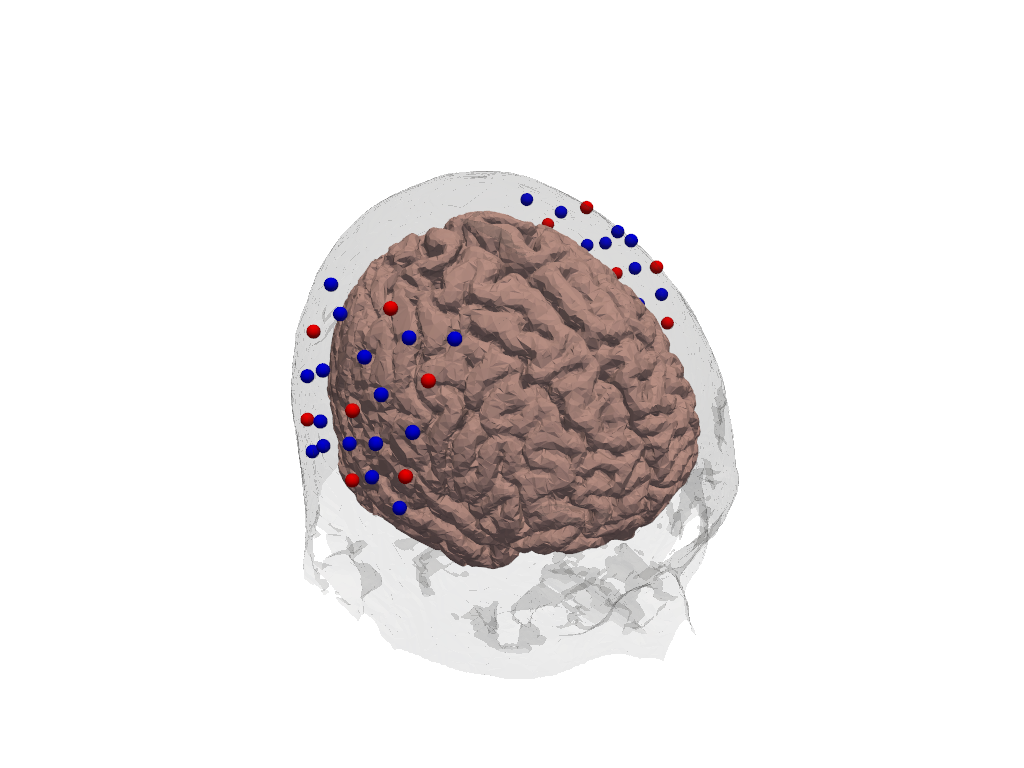

In [12]:
import cedalion.dataclasses as cdc
# keep only points that are not of type "landmark", i.e. source and detector points
geo3d_snapped = geo3d_snapped[geo3d_snapped.type != cdc.PointType.LANDMARK]

# now we plot the head same as before...
plt = pv.Plotter()
cedalion.plots.plot_surface(plt, head.brain, color="#d3a6a1")
cedalion.plots.plot_surface(plt, head.scalp, opacity=.1)
# but use the plot_labeled_points() function to add the snapped geo3d. The flag "show_labels" can be used to show the source, detector, and landmark names 
cedalion.plots.plot_labeled_points(plt, geo3d_snapped, show_labels=True)
plt.show()

## Surface Plot of 3D Scans
Uses the same function as for head models, **plot_surface()**

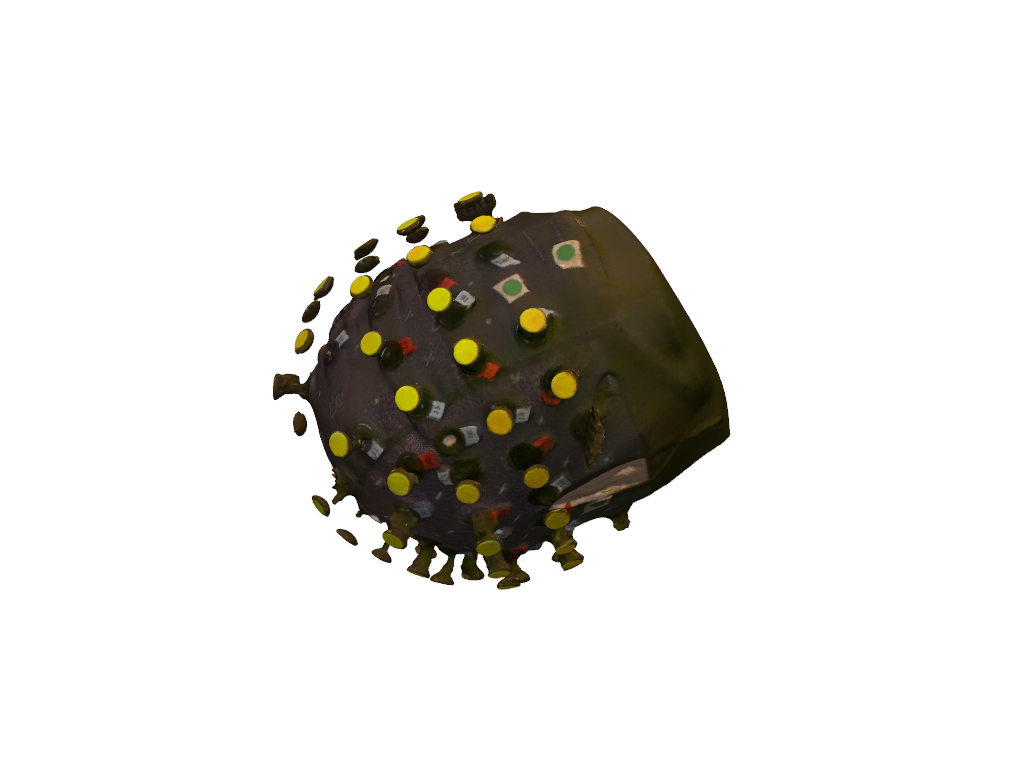

In [13]:
import cedalion.plots

plt = pv.Plotter()
get_landmarks = cedalion.plots.plot_surface(plt, pscan, opacity=1.0)
plt.show(interactive = True)

## Interactive 3D Plot to select Landmarks
using **plot_surface** with "pick_landmarks = True". Here we use a photogrammetric scan, and the landmarks are indicated by green dots. Right-clicking again on an existing landmark changes the label.

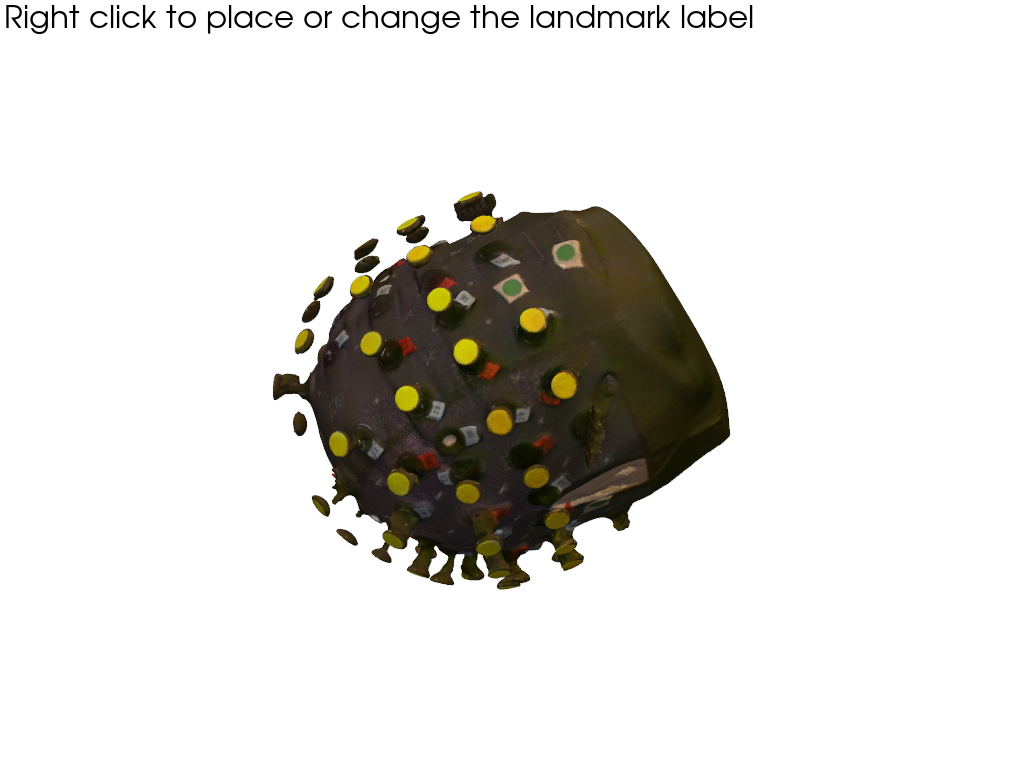

In [14]:
import cedalion.plots

plt = pv.Plotter()
get_landmarks = cedalion.plots.plot_surface(plt, pscan, opacity=1.0, pick_landmarks = True)
plt.show(interactive = True)

In [15]:
# for documentation purposes and to enable automatically rendered example notebooks we provide the hand-picked coordinates here too.
landmark_labels = ['Nz', 'Iz', 'Cz', 'Lpa', 'Rpa']
landmark_coordinates = [np.array([14.00420712, -7.84856869, 449.77840004]), 
                                  np.array([99.09920059, 29.72154755, 620.73876117]),
                                  np.array([161.63815139, -48.49738938, 494.91210993]),
                                  np.array([82.8771277, 79.79500128, 498.3338802]),
                                  np.array([15.17214095, -60.56186128, 563.29621021])]

# uncommentif you want to see your own picked results: when you are done run get_landmarks() to get the landmarks. 
# landmark_coordinates, landmark_labels = get_landmarks()
display (landmark_labels)

['Nz', 'Iz', 'Cz', 'Lpa', 'Rpa']

## Plot Probe Fluence / Sensitivity on Cortex
Plot the fluence between a source-detector pair, or the accumulated sensitivity profile on the cortex

### Fluence between two optodes

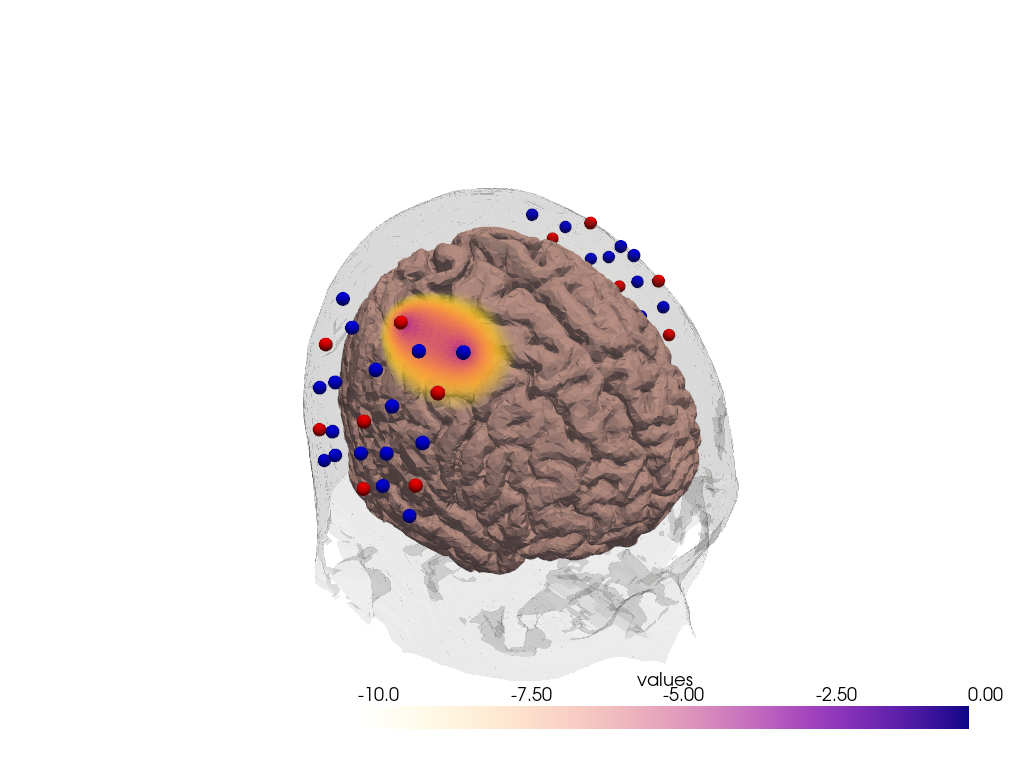

In [16]:
import cedalion.plots

# pull fluence values from the corresponding source and detector pair
f = fluence_all.loc["S12", 760].values * fluence_all.loc["D19",760].values
f[f<=0] = f[f>0].min()
f = np.log10(f)
vf = pv.wrap(f)

plt = pv.Plotter()

# plot fluence values
plt.add_volume(
    vf,
    log_scale=False, 
    cmap='plasma_r',
    clim=(-10,0),
)
# add head model
cedalion.plots.plot_surface(plt, head.brain, color="#d3a6a1")
cedalion.plots.plot_surface(plt, head.scalp, opacity=.1)
cedalion.plots.plot_labeled_points(plt, geo3d_snapped, show_labels=True)
plt.show()


### Plot Sensitivity Profile on Cortex
Using the calculated fluence. This will be simplified in the future to make it easier for you.

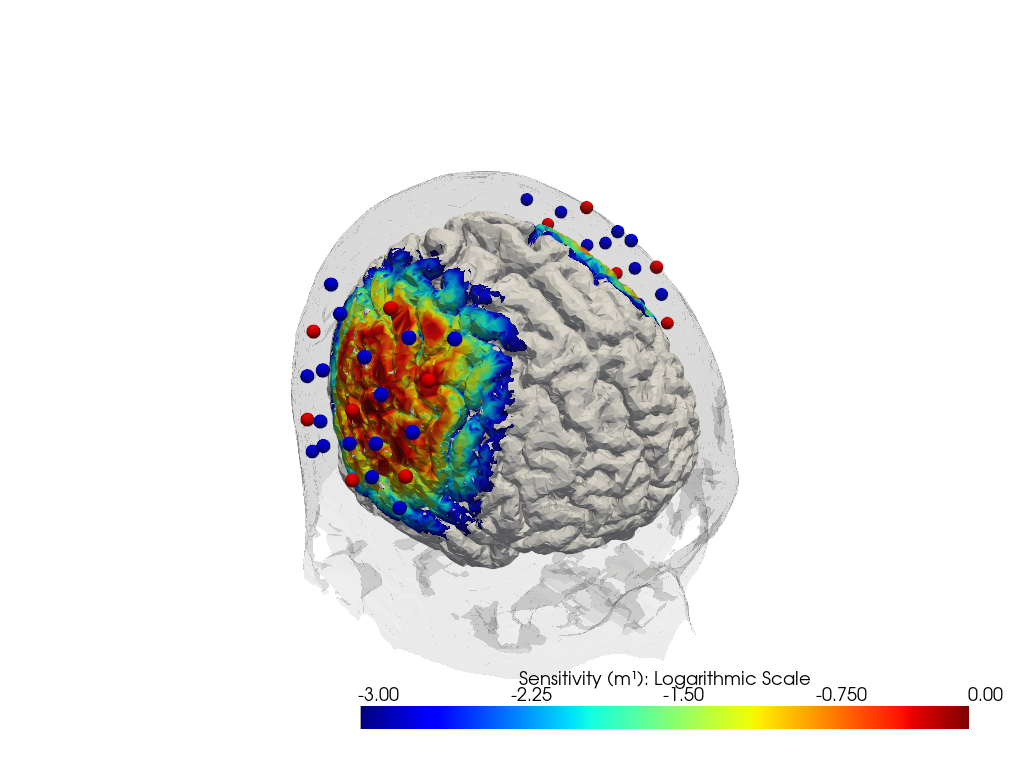

In [20]:
from cedalion.vis import plot_sensitivity_matrix
import cedalion.imagereco.forward_model as fwm

# to plot sensitivity on the cortex we need a forward model
fwm = cedalion.imagereco.forward_model.ForwardModel(head, geo3d_snapped, rec._measurement_lists["amp"])
Adot = fwm.compute_sensitivity(fluence_all, fluence_at_optodes)


plotter = plot_sensitivity_matrix.Main(
    sensitivity=Adot,
    brain_surface=head.brain,
    head_surface=head.scalp,
    labeled_points=geo3d_snapped,
)
plotter.plot(high_th=0, low_th=-3)
plotter.plt.show()

## Plot ImageRecon HRF Activation (from HD fNIRS/DOT) on Cortex
Since this requires a lot of preprocessing, please use the Image Reconstruction Jupyter Example Notebook [HERE](https://github.com/ibs-lab/cedalion/blob/main/examples/image_reconstruction.ipynb)